# Modality Concordance Analysis for Imaging Modalities

## What is Concordance?

Concordance measures how well each scan matches what surgeons actually find during the operation. It answers the question: "When a scan says it found something in a specific location, how often is it pointing to the right place?"

An easy way to think about it is if a scan says "the problem is in the left superior area," concordance tells us whether the surgeon will actually find the problem there, or if the scan was pointing to the wrong spot.

## How We Measured Concordance

We compared what each scan reported to what surgeons discovered and put the results into categories:

**Exact Match**: The scan got the location exactly right
**Side Match**: The scan got the correct side of the neck but not the exact spot  
**Incorrect**: The scan pointed to the completely wrong place

## What We Include and Exclude

We only looked at scans that actually tried to point to a specific location. We excluded:
- **Non-localizing scans**: When the scan couldn't find anything specific
- **No scan**: When that type of scan wasn't done on the patient
- **Missing data**: When we don't have complete information

We excluded these because concordance only makes sense when we can compare "the scan said here" versus "surgery found it here." If a scan didn't point anywhere specific, we can't judge if it was right or wrong.

## Why Concordance Matters

High concordance means surgeons can trust where the scan is pointing. If a scan has 90% concordance, then 9 out of 10 times when it points to a location, that's where the surgeon will find the problem. This helps doctors plan surgery and know which scans give the most reliable directions.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

preop_imaging_df = pd.read_excel('../Data/raw_imaging_data.xlsx')

In [128]:
# Clean column names by removing whitespace
preop_imaging_df.columns = preop_imaging_df.columns.str.strip()

## How the Concordance Function Works

The `check_concordance()` function compares what each scan found versus what surgeons actually discovered during the operation.

### What it takes as input:
- **row**: A single patient's data from our dataset
- **modality_col**: Which type of scan we're checking (like 'SPECT/CT' or 'Ultrasound')

### What it returns:
The function categorizes each scan result into one of these groups:

- **'Yes (Exact)'** - Scan found the exact same location as surgery
- **'Yes (Side)'** - Scan got the right side of the neck but not the exact spot  
- **'Incorrect Localization'** - Scan pointed to the wrong place entirely
- **'Non-localizing'** - Scan couldn't find anything specific
- **'No Scan'** - Patient didn't get this type of scan
- **'Unknown'** - Missing data that we can't analyze


In [129]:
def check_concordance(row, modality_col):
    
    imaging = row[modality_col]
    surgical = row['Surgical Findings']

    # Returns Unknown if imaging or surgical data is missing
    if pd.isnull(imaging) or pd.isnull(surgical):
        return 'Unknown'

    # Handles No Scan and Non-localizing 
    if imaging == 'No Scan':
        return 'No Scan'
    if imaging == 'Non-localizing':
        return 'Non-localizing'

    # If surgery found 4 gland hyperplasia, any single imaging finding is incorrect means a false positive
    if 'hyperplasia' in surgical.lower():
        return 'Incorrect Localization'

    # Splits and cleans imaging and surgical gland strings into sets
    imaging_glands = [g.strip().lower() for g in imaging.split(',')]
    surgical_glands = [g.strip().lower() for g in surgical.split(',')]
    imaging_set = set(imaging_glands)
    surgical_set = set(surgical_glands)

    # Exact match is when all surgical glands are found in imaging
    if surgical_set.issubset(imaging_set):
        return 'Yes (Exact)'

    # Extracts the imaging side
    imaging_sides = set()
    for ig in imaging_glands:
        if 'left' in ig:
            imaging_sides.add('left')
        if 'right' in ig:
            imaging_sides.add('right')

    # Only return 'Yes (Side)' if all surgical gland sides are found
    for sg in surgical_glands:
        if 'left' in sg and 'left' not in imaging_sides:
            return 'Incorrect Localization'
        if 'right' in sg and 'right' not in imaging_sides:
            return 'Incorrect Localization'

    return 'Yes (Side)'

In [130]:
# Loops through modalities and collects counts + percentages
summary_data = []

for modality in modalities:
    concordance_col = modality + ' Calculated Concordance'

    # Calculates concordance for each row and stores in a new column
    preop_imaging_df[concordance_col] = preop_imaging_df.apply(
        lambda row: check_concordance(row, modality), axis=1
    )
    
    # Filters to localizing rows only
    localizing_df = preop_imaging_df[
        ~preop_imaging_df[concordance_col].isin(['Unknown', 'Non-localizing'])
    ].copy()
    
    # Calculates value counts and total count
    counts = localizing_df[concordance_col].value_counts()
    total = counts.sum()
    
    for match_type, count in counts.items():
        pct = round((count / total) * 100 if total > 0 else 0, 2)
        
        # Appends results as dictionaries to summary_data list
        summary_data.append({
            'Modality': modality,
            'Concordance': match_type,
            'Count': count,
            'Percentage': pct
        })

In [131]:
# Converts to DataFrame
concordance_summary_df = pd.DataFrame(summary_data)


# Reorders columns 
ordered_cols = ['Yes (Exact)', 'Yes (Side)', 'Incorrect Localization']


# Displays results
display(concordance_summary_df)
display(pivot_df)

,Modality,Concordance,Count,Percentage
0,SPECT/CT,Yes (Side),82,46.07
1,SPECT/CT,Yes (Exact),72,40.45
2,SPECT/CT,Incorrect Localization,24,13.48
3,4D CT Scan,Yes (Exact),78,45.09
4,4D CT Scan,Yes (Side),58,33.53
5,4D CT Scan,Incorrect Localization,37,21.39
6,Ultrasound,Yes (Side),43,55.13
7,Ultrasound,Yes (Exact),26,33.33
8,Ultrasound,Incorrect Localization,9,11.54
9,Sestamibi,Yes (Side),62,54.87


Concordance,Yes (Exact),Yes (Side),Incorrect Localization
Modality,,,
4D CT Scan,45.09,33.53,21.39
MRI,50.00,25.00,25.00
SPECT/CT,40.45,46.07,13.48
Sestamibi,40.71,54.87,4.42
Ultrasound,33.33,55.13,11.54


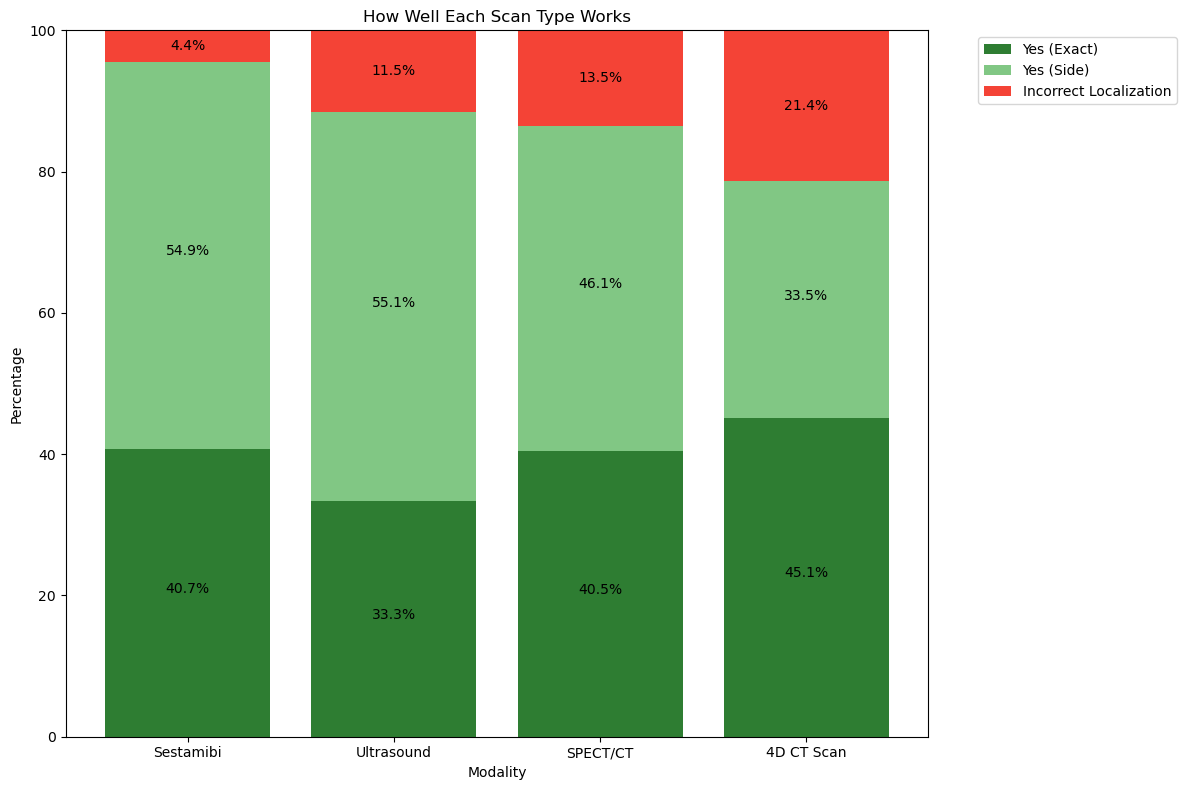

In [132]:
# Remove MRI and sort by accuracy (best to worst)
df_plot = pivot_df.drop('MRI').sort_values('Incorrect Localization')

# Create stacked bar chart
plt.figure(figsize=(12, 8))
colors = ['#2E7D32', '#81C784', '#F44336']

# Plot stacked bars
bottom_vals = df_plot['Yes (Exact)']
middle_vals = df_plot['Yes (Side)']
top_vals = df_plot['Incorrect Localization']

plt.bar(df_plot.index, bottom_vals, color=colors[0], label='Yes (Exact)')
plt.bar(df_plot.index, middle_vals, bottom=bottom_vals, color=colors[1], label='Yes (Side)')
plt.bar(df_plot.index, top_vals, bottom=bottom_vals + middle_vals, color=colors[2], label='Incorrect Localization')

# Add percentage labels on bars
for i in range(len(df_plot.index)):

    # Bottom section
    plt.text(i, bottom_vals[i]/2, f'{bottom_vals[i]:.1f}%', ha='center')

    # Middle section  
    plt.text(i, bottom_vals[i] + middle_vals[i]/2, f'{middle_vals[i]:.1f}%', ha='center')

    # Top section
    plt.text(i, bottom_vals[i] + middle_vals[i] + top_vals[i]/2, f'{top_vals[i]:.1f}%', ha='center', va='center')

plt.title('How Well Each Scan Type Works')
plt.ylabel('Percentage')
plt.xlabel('Modality')
plt.ylim(0, 100)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Results Summary

### How Well Each Scan Gets the Location Right
1. **Sestamibi: 95.6% Accurate** - When this scan points to a spot, it's almost always right
2. **Ultrasound: 88.5% Accurate** - Pretty reliable, but makes mistakes about 1 in 10 times  
3. **SPECT/CT: 86.5% Accurate** - Generally trustworthy, though not quite as good as ultrasound
4. **4D CT Scan: 78.6% Accurate** - The least reliable of the four, getting it wrong about 1 in 5 times

### Key Takeaways
- **Sestamibi** is the winner so we can make an inference that when it finds something, you can trust it
- **Nuclear medicine scans** like Sestamibi and SPECT/CT tend to be more accurate than the others
- **4D CT** might find things that other scans miss, but it's more likely to point to the wrong spot
- Many scans get the right side of the neck but miss the exact location, that's still helpful for surgeons
- Even the least accurate scan is right about 4 out of 5 times, which gives doctors useful information to work with
